In [12]:
from collections import defaultdict
# {Legend}, {log}, {Graph Title}
FNAME="../jobs/logo_learning_curves"
curves = defaultdict(list)
with open(FNAME) as f:
    lines = [line.strip()for line in f.readlines() if (not line.startswith("#") and len(line.strip()) > 0)]
    for line in lines:
        legend, log, title = line.split(",")
        curves[title.strip()].append((legend.strip(), log.strip()))

In [13]:
# TODO -- manually add the last ordering
# TODO -- figure out how to get these into a dataframe with a legend
import numpy as np

In [25]:
PREFIX = '~/Desktop/zyzzyva/code/ec/jobs/'
def extract_curves(log_output, max_iter=18, n_tasks = 111):
    log_output = log_output.split("\\n")
    log_output = [str(l) for l in log_output]
    log_output = [l for l in log_output if "Evaluating on testing tasks using the recognizer." not in l]
    log_output = [l for l in log_output if "Found 0 " not in l]
    iters = int(len(log_output) / 2)*2
    xs, ys = [], []
    for i in range(0,iters ,2):
        try:
            iter_line, hits_line = log_output[i], log_output[i+1]
            iter = int(iter_line.split(": ")[-1])
            hits = int(hits_line.split()[1].split("/")[0])
            if iter < max_iter:
                xs.append(iter)
                ys.append(float(hits / n_tasks) * 100)
            
        except:
            pass
    if len(xs) > 0:
        if xs[0] != 0:
            xs, ys = [0] + xs, [0] + ys
    return xs, ys
        
import subprocess
curve_vals = defaultdict(lambda: defaultdict(list))
for curve in curves:
    print(f"Graph: {curve} with n={len(curves[curve])}")
    for legend, log in curves[curve]:
        p = subprocess.Popen(f"grep -a 'testing tasks' {PREFIX}{log}", stdout=subprocess.PIPE, shell=True)
        output,_ = p.communicate() 
        output = str(output)
        if len(output.strip()) < 2:
            print(f"No output for: {log}")
        else:
            xs, ys = extract_curves(output)
            curve_vals[curve][legend].append((xs, ys))

Graph: "Sentence Curriculum" with n=2


In [26]:
# Print a table of the best model and the average values for each run
for curve in curve_vals:
    print(f"{curve}")
    for legend in curve_vals[curve]:
        max_vals = [max(ys) for (xs, ys) in curve_vals[curve][legend] if len(ys) > 0]
        print(f"{legend} | Best : {round(np.max(max_vals), 2)} | Average: {round(np.mean(max_vals), 2)} | ")
    print("\n")

"Sentence Curriculum"
(Ours) | Best : 76.58 | Average: 76.58 | 
DreamCoder | Best : 31.53 | Average: 31.53 | 




In [27]:
def build_dataframe(curve_vals, curve):
    # For a given plot, extract all of the 
    iterations = []
    solved_tasks = []
    model = []
    for pal_idx, legend in enumerate(curve_vals[curve]):
        for xs, ys in curve_vals[curve][legend]:
            iterations += xs
            solved_tasks += ys
            model += [legend] * len(xs)
    d = {
            "Iterations" : iterations,
            "% Solved tasks" : solved_tasks,
            "Model" : model
    }
    return pd.DataFrame(data=d)

<Figure size 216x288 with 0 Axes>

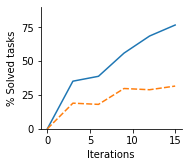

In [40]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
for curve in curve_vals:
    f = plt.figure(figsize=(3,4))
    df = build_dataframe(curve_vals, curve)
    ax = sns.relplot(x="Iterations", y="% Solved tasks",
                hue="Model", style="Model",
                kind="line", data=df)
    ax.fig.set_size_inches(3,2)
    ax._legend.remove()
    ax.axes[0,0].set_ylim(0, 90)
    ax.set(yticks=(np.arange(0, 100, 25)))

#     ax.set_title(f"{curve}")
#     ax.set(ylim=(0, 111))
#     ax.set(xticks=(np.arange(0, 16)))
#     ax.set(yticks=(np.arange(0, 111, 10)))

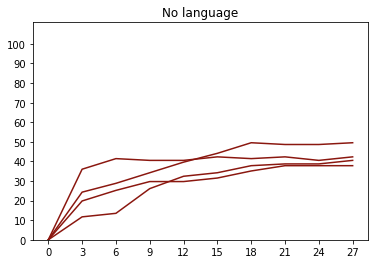

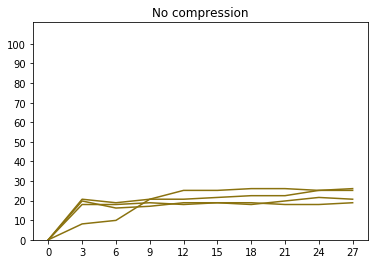

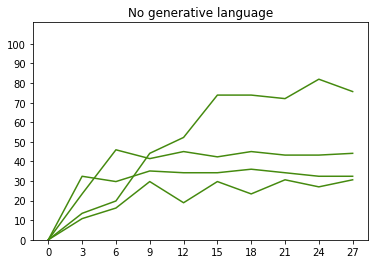

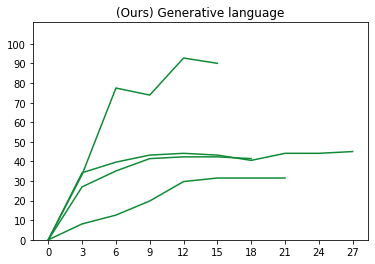

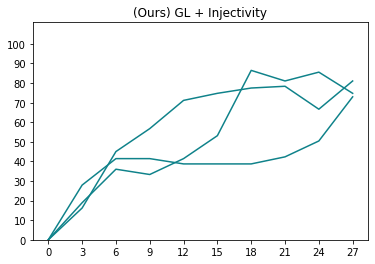

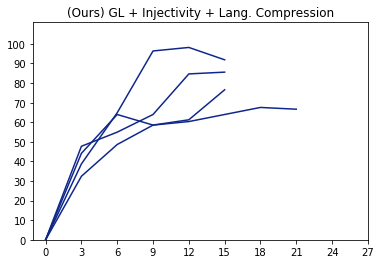

In [242]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
for curve in curve_vals:
    # Build dataframe from the curves
    palette = sns.hls_palette(8, l=.3, s=.8)
    for pal_idx, legend in enumerate(curve_vals[curve]):
        f = plt.figure(figsize=(6,4))
        for xs, ys in curve_vals[curve][legend]:
            ax = sns.lineplot(x=xs, y=ys, color=palette[pal_idx])
            ax.set_title(f"{legend}")
            ax.set(ylim=(0, 111))
            ax.set(xticks=(np.arange(0, 28, 3)))
            ax.set(yticks=(np.arange(0, 101, 10)))